In [ ]:
%load_ext autoreload
%autoreload 2

# Sentiment Analysis with Logistic Regression

In this notebook, we will use logistic regression to perform a sentiment analysis on tweets. 

Given a tweet, we will decide if it has a positive sentiment or a negative one.

We will implement logistic regression from scratch. For this notebook to work correctly, you will need to have assignment 2 completed. This requires you to implement the `logistic_regression` and `features` module of our `htwgnlp` package.

Remember that you can find your tasks by searching for `TODO ASSIGNMENT-2` in your IDE.

In [1]:
from nltk.corpus import twitter_samples
import numpy as np

## Dataset

We will use the Twitter dataset from `nltk`.

It contains 10,000 tweets with positive and negative sentiment labels.

In [2]:
postive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")
n_samples = len(postive_tweets) + len(negative_tweets)
n_pos = len(postive_tweets)
n_neg = len(negative_tweets)

print("Total number of tweets: ", n_samples)
print("Number of positive tweets: ", n_pos)
print("Number of negative tweets: ", n_neg)

Total number of tweets:  10000
Number of positive tweets:  5000
Number of negative tweets:  5000


For this exercise, we do a simple 80/20 train/test split.

In [3]:
# split the data 80/20
n_train = int(n_samples * 0.8)
n_test = n_samples - n_train

print("Number of training samples: ", n_train)
print("Number of test samples: ", n_test)

Number of training samples:  8000
Number of test samples:  2000


Since we know that the classes in the dataset are balanced, we want both the training and test set to contain 50% of the positive and 50% of the negative tweets.

That means, in our case, the training set should contain 4000 tweets of each class, while the test set should contain 1000 tweets of each class.

In [4]:
n = int(n_train / 2)

# training data
train_data_pos = postive_tweets[:n]
train_data_neg = negative_tweets[:n]
print(f"train_data_pos: {len(train_data_pos)}")
print(f"train_data_neg: {len(train_data_neg)}")

# test data
test_data_pos = postive_tweets[n:]
test_data_neg = negative_tweets[n:]
print(f"test_data_pos: {len(test_data_pos)}")
print(f"test_data_neg: {len(test_data_neg)}")

# build train and test datasets
train_data = train_data_pos + train_data_neg
test_data = test_data_pos + test_data_neg
print(f"train_data: {len(train_data)}")
print(f"test_data: {len(test_data)}")

train_data_pos: 4000
train_data_neg: 4000
test_data_pos: 1000
test_data_neg: 1000
train_data: 8000
test_data: 2000


For the labels, we create a numpy array that holds the sentiment labels (0 for negative and 1 for positive).

The label arrays should be of shape (n_samples, 1).

In [5]:
# create labels
y_train = np.append(
    np.ones((len(train_data_pos), 1)), np.zeros((len(train_data_neg), 1)), axis=0
)
y_test = np.append(
    np.ones((len(test_data_pos), 1)), np.zeros((len(test_data_neg), 1)), axis=0
)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (8000, 1)
y_test shape:  (2000, 1)


## Preprocessing

For the preprocessing, we will use the `TweetProcessor` class from the previous exercise. It is located in the `preprocessing` module of our `htwgnlp` package.

In [6]:
from htwgnlp.preprocessing import TweetProcessor

processor = TweetProcessor()

For the next step, feature extraction, we need the training samples in a preprocessed form.

The preprocessing of the whole training set may take a while.

In [7]:
train_data_processed = [processor.process_tweet(tweet) for tweet in train_data]
train_data_processed[0]

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

## Frequencies

As the features for our sentiment analysis, we will use the frequencies of positive and negative words in each tweet.

Together with the bias term, we will have a feature vector of length 3 for each tweet:

$$
\mathbf{v} = \begin{pmatrix}
    1 \\
    n_{pos} \\
    n_{neg} \\
\end{pmatrix}
$$


In [8]:
from htwgnlp.features import CountVectorizer

vectorizer = CountVectorizer()

Now we can build the dictionary of word frequencies.

In [9]:
vectorizer.build_word_frequencies(train_data_processed, y_train)

In [10]:
vectorizer.word_frequencies["happi", 1]

162

Let's take a look at a specific example:

The **raw tweet** looks like this:

In [11]:
train_data[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

After the **preprocessing**, we get the tweet in its **tokenized form**:

In [12]:
tweet = processor.process_tweet(train_data[0])
tweet

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

The `get_features` function gives us the **numeric representation** of the tweet:

In [13]:
vectorizer.get_features(tweet)

array([   1, 3133,   61])

Note that
- the first element in the tuple is the bias term, 
- the second element corresponds to the frequency of words in the positive class, and
- the third element holds the frequency of words in the negative class.

Here is another way that can help you to interpret the feature vector:

In [14]:
for token in tweet:
    print(
        f"number of times the word {token:<15} appeared in tweets labeled as positive: {vectorizer.word_frequencies[(token, 1)]:<4} as negative: {vectorizer.word_frequencies[(token, 0)]}"
    )

number of times the word followfriday    appeared in tweets labeled as positive: 23   as negative: 0
number of times the word top             appeared in tweets labeled as positive: 30   as negative: 5
number of times the word engag           appeared in tweets labeled as positive: 7    as negative: 0
number of times the word member          appeared in tweets labeled as positive: 14   as negative: 6
number of times the word commun          appeared in tweets labeled as positive: 27   as negative: 1
number of times the word week            appeared in tweets labeled as positive: 72   as negative: 47
number of times the word :)              appeared in tweets labeled as positive: 2960 as negative: 2


## Pipeline

To make sure that every sample runs through the same processing, we encapsulate the preprocessing and feature extraction in a `tweet_pipeline` function.

In [15]:
def tweet_pipeline(tweet):
    tweet = processor.process_tweet(tweet)
    return vectorizer.get_features(tweet)

## Model Training

We will use our own implementation of logistic regression provided in the `logistic_regression` module of our `htwgnlp` package.

In [16]:
from htwgnlp.logistic_regression import LogisticRegression

model = LogisticRegression()

To get the features that we need for the training, we need to run the `tweet_pipeline` function from above on all training samples.

This gives us the feature matrix `X_train`.

In [17]:
X_train = np.zeros((n_train, 3))
for i in range(n_train):
    X_train[i, :] = tweet_pipeline(train_data[i])

X_train.shape

(8000, 3)

Now, together with the label vector `y_train`, we have all required input variables ready to train our logistic regression model.

We can do so by calling the `fit` method.

In [18]:
theta, cost = model.fit(X_train, y_train)
print(f"theta:\n{theta}")
print(f"cost:\n{cost}")

theta:
[[ 6.03443427e-08]
 [ 5.38196083e-04]
 [-5.58301889e-04]]
cost:
[[0.2252131]]


If you implemented the assignment correctly, the returned values for the `cost` and the weights `theta` should be:

```python
theta:
[[ 6.03443427e-08]
 [ 5.38196083e-04]
 [-5.58301889e-04]]
cost:
[[0.2252131]]
```

> Note that depending on your preprocessing pipeline from the previous exercise, your results might differ slightly. This should be no problem, as long as the values are in the same order of magnitude.

## Testing

To test the model, we will use the test set that we created in the beginning. 

To obtain the test set features `X_test`, we need the same preprocessing steps as for the training set. We will reuse our simple `tweet_pipeline` for this.

In [19]:
X_test = np.zeros((n_test, 3))
for i in range(n_test):
    X_test[i, :] = tweet_pipeline(test_data[i])

To predict the labels, we can use the `predict` method of our trained model.

In [20]:
y_pred = model.predict(X_test)
y_pred

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

Here is a single example. The prediction should be 1, which corresponds to a positive sentiment.

```python
# expected output
tweet: @tillyyandtroye you're welcome :)
prediction: [1]
```

In [21]:
print(f"tweet: {test_data[111]}")
x_i = tweet_pipeline(test_data[111])
print(f"prediction: {model.predict(x_i)}")

tweet: @tillyyandtroye you're welcome :)
prediction: [1]


You can try it yourself and predict your own tweets:

In [22]:
tweet = "Konstanz is a great place to live!"
x_i = tweet_pipeline(tweet)
print(f"prediction: {model.predict(x_i)}")

prediction: [1]


## Evaluation

We can calculate the accuracy of our model by comparing the predicted values to the test set values.

There are many ways to do it. Here is an approach that uses element-wise comparison of two arrays. This will return an array of booleans, where each element is True if the predicted value is equal to the test set value at the same index, and False otherwise. 

Numpy then converts booleans to integers (True becomes 1, False becomes 0). That is why the mean of the array will be the accuracy of the model.

In [23]:
# accuracy
(y_pred == y_test).mean() * 100

99.5

## Error Analysis

We can find the error cases by checking the predicted labels against the test set labels.

We can use `np.nonzero` to get the indices of the error cases. Using these indices, we can inspect the corresponding samples from the test set.

> Note that `np.nonzero` should be preferred over `np.where`, as the [docs](https://numpy.org/doc/stable/reference/generated/numpy.where.html) say.
> Also note that `np.nonzero` returns a tuple of arrays, which is why we need to access the first element of the tuple to get our indices.

In [24]:
error_cases = np.nonzero((y_pred.flatten() != y_test.flatten()))[0]
error_cases

array([  84,  129,  136,  530,  753,  822, 1298, 1544, 1756, 1853])

The probabilities for each class can be obtained with the `predict_prob` method. This is interesting if we want to know how confident the model is about its prediction, which can be useful for error analysis.

In [25]:
y_prob = model.predict_prob(X_test)

Here we can take a look at the error samples.

What can you notice about the error cases and why do you think the misclassifications happened? 

In [26]:
for i in error_cases:
    print(
        f"sample: {i:>4}, predicted class: {y_pred[i]}, actual class: {y_test[i]} probability: {y_prob[i].item():7.4f}, tweet: {test_data[i]}"
    )

sample:   84, predicted class: [0], actual class: [1.] probability:  0.4892, tweet: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
sample:  129, predicted class: [0], actual class: [1.] probability:  0.4842, tweet: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
sample:  136, predicted class: [0], actual class: [1.] probability:  0.4842, tweet: I'm playing Brain Dots : ) #BrainDots http://t.co/aOKldo3GMj http://t.co/xWCM9qyRG5
sample:  530, predicted class: [0], actual class: [1.] probability:  0.4842, tweet: I'm playing Brain Dots : ) #BrainDots http://t.co/R2JBO8iNww http://t.co/ow5BBwdEMY
sample:  753, predicted class: [0], actual class: [1.] probability:  0.4964, tweet: off to the park to get some sunlight : )
sample:  822, predicted class: [0], actual class: [1.] probability:  0.4825, tweet: @msarosh Uff Itna Miss karhy thy ap :p
sample: 1298, predicted class: [1], actual cla

## Visualization of Word Frequencies

To get a better understanding of the model, we can also visualize the word frequencies for the positive and negative class.

The following code snippet visualizes some selected words along with their positive and negative frequencies in the corpus.

> Don't worry if the plotting code is not clear to you. It is not important for the exercise.

In [27]:
# select some words to appear in the report
keys = [
    "happi",
    "merri",
    "nice",
    "good",
    "bad",
    "sad",
    "mad",
    "best",
    "pretti",
    "❤",
    ":)",
    ":(",
    "😒",
    "😬",
    "😄",
    "😍",
    "song",
    "idea",
    "power",
    "play",
    "magnific",
]

# prepare the data for the plot: [<word>, <positive_count>, <negative_count>]
data = [
    [
        word,
        vectorizer.word_frequencies[(word, 1)],
        vectorizer.word_frequencies[(word, 0)],
    ]
    for word in keys
]
data

[['happi', 162, 18],
 ['merri', 1, 0],
 ['nice', 71, 17],
 ['good', 191, 83],
 ['bad', 14, 54],
 ['sad', 5, 100],
 ['mad', 3, 8],
 ['best', 49, 16],
 ['pretti', 17, 12],
 ['❤', 21, 15],
 [':)', 2960, 2],
 [':(', 1, 3675],
 ['😒', 2, 3],
 ['😬', 0, 2],
 ['😄', 3, 1],
 ['😍', 1, 0],
 ['song', 16, 25],
 ['idea', 24, 8],
 ['power', 6, 5],
 ['play', 37, 39],
 ['magnific', 1, 0]]

/home/i557480/htwg/htwg-practical-nlp/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


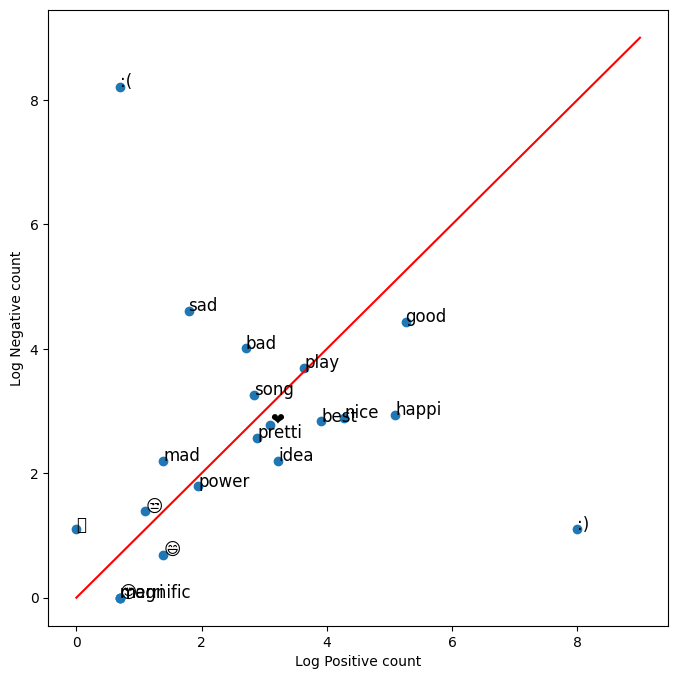

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# convert positive and negative raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])
y = np.log([x[2] + 1 for x in data])

# Plot a dot for each pair of words
ax.scatter(x, y)

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color="red")  # Plot the red line that divides the 2 areas.
plt.show()

## Conclusion

This notebook demonstrated how to use logistic regression for sentiment analysis.

With a simple classifier like this, we can already achieve an accuracy of over 99%.

But keep in mind that the `nltk` tweet dataset, while being a good starting point, is not a good representation of real-world data.

Also we are working in a lab environment, and the primary goal of this notebook is not efficiency, but to demonstrate the concepts of logistic regression in a understandable way.

For a production scenario, what parts of the code do you think should be improved?